 ## EELT 7023 - Tópicos Especiais em Identificação de Sistemas

#### Aluno:

### $$\textbf{Exercício 5}$$

$\textbf{Objetivo:}$ Utilizar o conjunto de dados de $\omega_k$ e $G(j\omega_k)$ para estimar modelos utilizando o método de Levy.

Deseja-se utilizar um equacionamento tal que seja possível escolher facilmente a ordem do numerador e do denominador do modelo que se deseja estimar, de modo a avaliar o comportamento de diferentes modelos

Apenas para recordar, a função de transferência $G(s)$ é dada por

$$G(s) = \frac{2s}{1+2s+6s^2}$$

onde $s$ é a frequência complexa da transformada de Laplace e pode ser substituída por $j\omega$.

### DADOS DO SISTEMA REAL

In [1]:
# Função para gerar pontos espaçados logaritmicamente
LogSpace(start, stop, steps) = [10^i for i in range(log10(start), log10(stop), length=steps)]

# Parâmetros da simulação
total_points = 1000
# Limites de frequência
ω_start, ω_stop = 0.01, 10
# Coeficientes do numerador e do denominador
num = [0, 2]
den = [1, 2, 6]


# Vetor de frequência
ω =LogSpace(ω_start, ω_stop, total_points)

numerador = zeros(total_points)

# A notação de Julia para valores imaginários é "im" no lugar do tradicional "j"
for n=1:length(num)
    numerador = numerador .+ (ω * 1im).^(n - 1) * num[n];
end

denominador = zeros(total_points);
for d=1:length(den)
    denominador = denominador .+ (ω * 1im).^(d - 1) * den[d];
end

G = numerador ./ denominador;

Os gráficos a seguir apresentam o ângulo e o módulo do sistema ser identificado

In [2]:
G_mag = abs.(G);
G_phase = angle.(G) * 180 / pi;

In [3]:
# Biblioteca necessária para plotar gráficos
using Plots
pyplot()

Plots.PyPlotBackend()

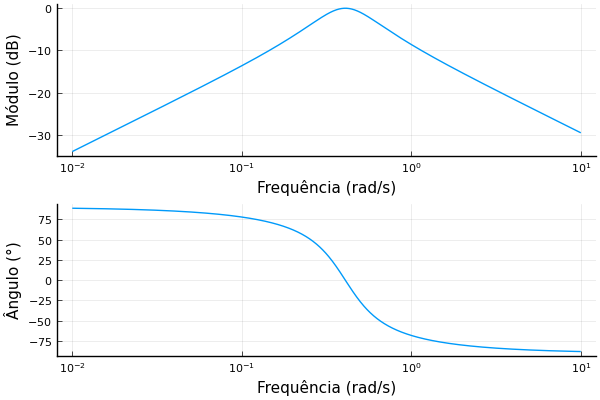

In [4]:
plot_mag = plot(ω, 20*log10.(G_mag), xlabel="Frequência (rad/s)", yaxis="Módulo (dB)", xaxis=:log)
plot_pha = plot(ω, G_phase, xlabel="Frequência (rad/s)", yaxis="Ângulo (°)", xaxis=:log)

plot(plot_mag, plot_pha, layout=(2,1), legend=false)

## ALGORITMO DE LEVY

In [5]:
function modelo_levy(na, nb, y)
    # Criação da matriz M
    M = Array{Complex{Float64}, 2}(undef, total_points, na + nb + 1)
    M[:, 1] .= 1

    # Coeficientes relacionados ao numerador
    for i=1:nb
        m_i = i + 1
        M[:, m_i] = (ω * 1im) .^ i
    end

    # Coeficientes relacionados ao denominador
    for i=1:na
        m_i = i + nb + 1
        M[:, m_i] = -1 * y .* (ω * 1im) .^ i
    end

    # Matrizes adaptadas
    M_til = [real(M); imag(M)]
    y_til = [real(y); imag(y)]

    # Cálculo de theta
    θ = M_til \ y_til

    b_array = θ[1:nb+1]
    a_array = θ[nb+2:nb+na+1]

#     println("Vetor θ igual a:")
#     println(round.(θ, digits=6))
#     println("")

    # Numerador do modelo obtido
    num_til = zeros(total_points)

    for n=1:length(b_array)
        num_til = num_til + (ω * 1im).^(n - 1) * b_array[n];
    end

    # Denominador do modelo obtido
    den_til = ones(total_points);
    for d=1:length(a_array)
        den_til = den_til + (ω * 1im) .^ d * a_array[d];
    end

    G_modelo = num_til ./ den_til;
    return G_modelo
end

modelo_levy (generic function with 1 method)

Agora será realizada a comparação do sistema real com um modelo com a estrutura igual à do sistema original, ou seja, $na=2$ e $nb=1$

Valor de J_til é 2.869601915038034e-28


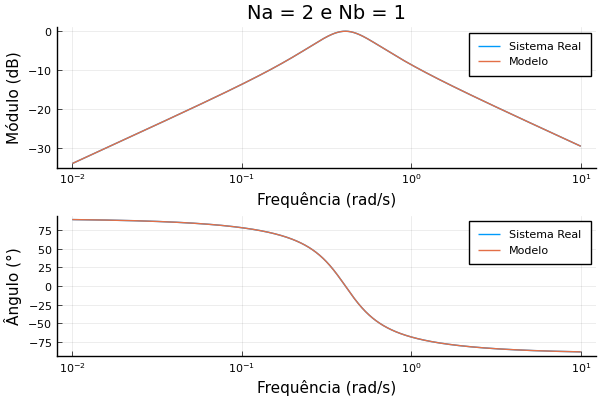

In [6]:
function plota_modelo(na, nb)
    modelo = modelo_levy(na, nb, G)

    modelo_mag = abs.(modelo)
    modelo_pha = angle.(modelo) * 180 / pi

    J_til = sum(abs.(modelo - G) .^ 2)
    println("Valor de J_til é $J_til")

    plot_mag = plot(ω, 20*log10.(G_mag), xlabel="Frequência (rad/s)", 
                    yaxis="Módulo (dB)", xaxis=:log, label="Sistema Real")
    plot!(ω, 20*log10.(modelo_mag), label="Modelo", title="Na = $na e Nb = $nb")

    plot_pha = plot(ω, G_phase, xlabel="Frequência (rad/s)", yaxis="Ângulo (°)", 
                    xaxis=:log, label="Sistema Real")
    plot!(ω, modelo_pha, label="Modelo")

    plot(plot_mag, plot_pha, layout=(2,1))
end

plota_modelo(2, 1)

Observa-se que o modelo obtido pelo método de Levy se aproxima muito do sistema real, apresentando um valor da ordem de $10^{-28}$ para a função objetivo aproximada.

Por fim, pretende-se obter o modelo para algumas combinações de valores distintos de $na$ e $nb$.

In [7]:
using DataFrames

total_na, total_nb = 10, 10

results = zeros(Float64, total_na, total_nb)

for na = 1:total_na
    for nb = 1:total_nb
        model = modelo_levy(na, nb, G)
        
        J_til = sum(abs.(model - G) .^ 2)

        results[na, nb] = J_til
    end
end

Como é difícil representar os resultados de forma gráfica, optou-se por apresentá-los na forma de tabela. Cada coluna corresponde aos número de coeficientes do **numerador**, enquanto as linhas correspondem ao número de coeficientes no **denominador**.

In [8]:
using Formatting

line_format = "{:<3}" * (" | {:<10.4e}"^total_nb)


print("na\\nb")
for nb = 1:total_nb
    printfmt(" | {:<9}", nb)
end
println()
println("*"^120)

for na = 1:total_na
    printfmt("{:<5}", na)
    for nb = 1:total_nb
        printfmt(" | {:<9.3e}", results[na, nb])
    end
    println()
    println("-"^120)
end

na\nb | 1         | 2         | 3         | 4         | 5         | 6         | 7         | 8         | 9         | 10       
************************************************************************************************************************
1     | 1.133e+02 | 1.136e+02 | 1.124e+02 | 1.126e+02 | 1.116e+02 | 1.116e+02 | 1.108e+02 | 1.109e+02 | 1.102e+02 | 1.102e+02
------------------------------------------------------------------------------------------------------------------------
2     | 2.870e-28 | 3.998e-29 | 1.216e-29 | 1.502e-28 | 1.374e-29 | 9.812e-29 | 4.218e-29 | 3.224e-29 | 9.412e-29 | 9.073e-29
------------------------------------------------------------------------------------------------------------------------
3     | 1.475e-28 | 1.429e-28 | 3.206e-28 | 8.648e-29 | 2.581e-29 | 1.427e-28 | 1.125e-28 | 5.970e-29 | 1.774e-28 | 1.319e-28
------------------------------------------------------------------------------------------------------------------------
4     | 1.54

É curioso notar que os modelos com maior quantidade de parâmetros não necessariamente apresentam resultados melhores do que aqueles com menos parâmetros.

Também não é possível estabelecer facilmente uma relação entre modelos com uma mesma quantidade de coeficientes no numerador ou no denominador. Cada modelo se comporta de uma maneira diferente.

Contudo, uma conclusão interessante é que, apesar de o sistema original possuir $na=2$ e $nb=1$, essa combinação não é a que apresenta o melhor resultado. De fato, o melhor modelo dentre todos os calculados foi o  obtido para $na=2$ e $nb=3$.

A título de ilustração, serão plotados os gráficos de alguns modelos distintos para permitir uma comparação visual.

Valor de J_til é 1.2155284349368051e-29


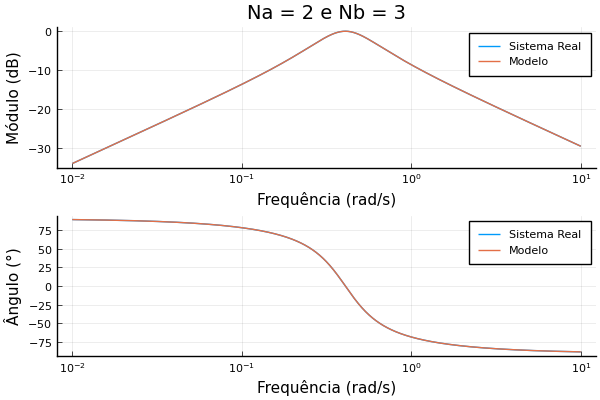

In [9]:
na, nb = 2, 3
plota_modelo(na, nb)

Valor de J_til é 1.7497861821034082e-26

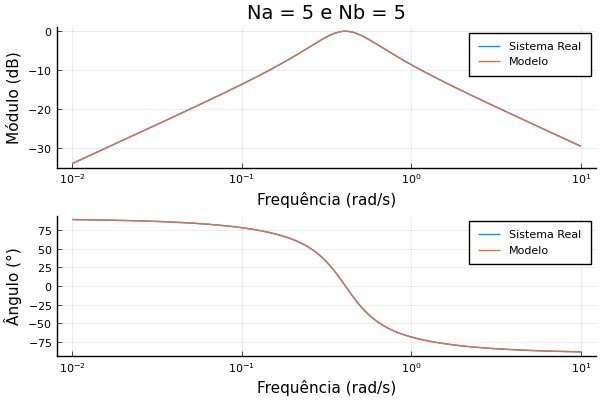

In [10]:
na, nb = 5, 5
plota_modelo(na, nb)

Valor de J_til é 111.5887263570328

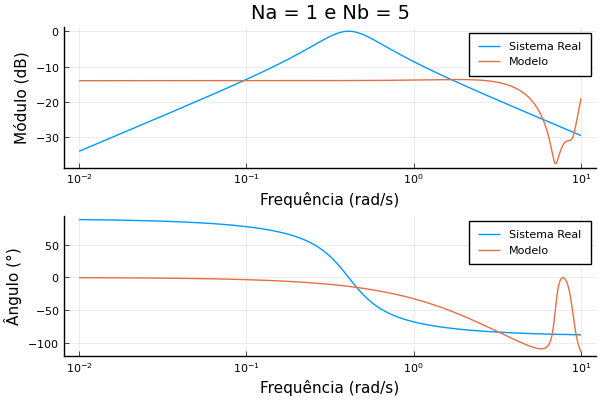

In [11]:
na, nb = 1, 5
plota_modelo(na, nb)

Valor de J_til é 110.21432915486918


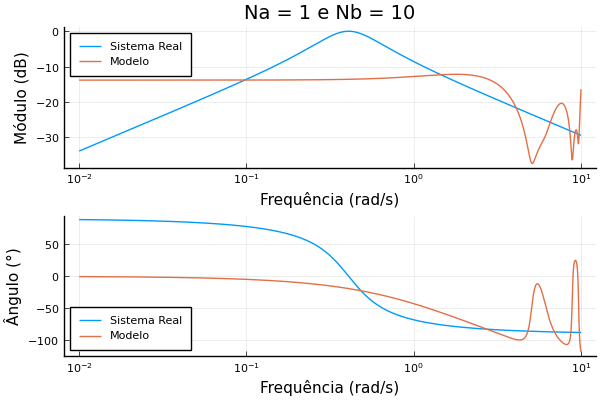

In [12]:
na, nb = 1, 10
plota_modelo(na, nb)

Valor de J_til é 3.162822609217996e-23


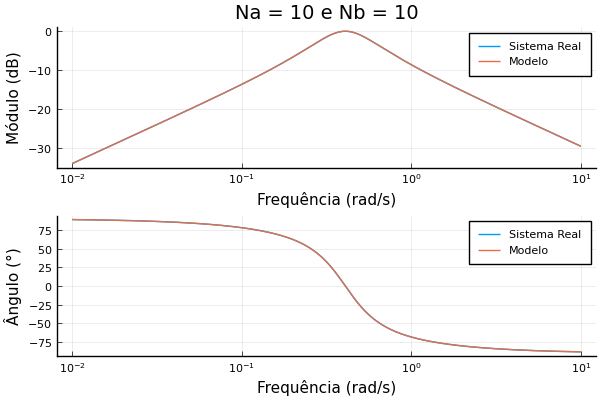

In [13]:
na, nb = 10, 10
plota_modelo(na, nb)

É possível concluir que, por mais que alguns modelos tenham apresentado resultados com função custo cerca de 6 ordens de grandeza acima da melhor solução, graficamente as curvas ainda permanecem muito próximas do sistema real.

As únicas discrepâncias observadas que vale comentar são as referentes a $na=1$. Como o sistema original possui dois polos, é muito difícil obter uma resposta similar utilizando menos polos. Por isso modelos mais complexos apresentaram resultados bons, porque uma maior quantidade de polos corresponde a modelos mais complexos. Já os modelos que utilizaram menos polos correspondem a modelos simples demais para representar o sistema em questão.